In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

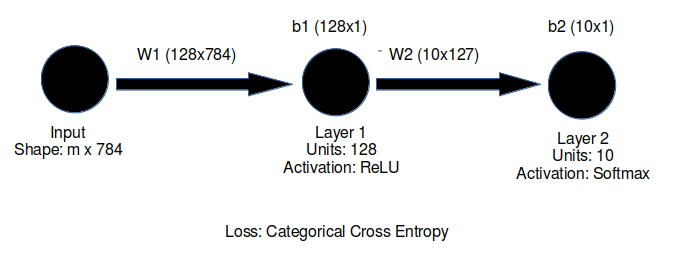

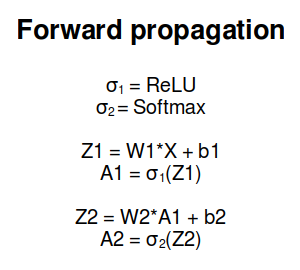

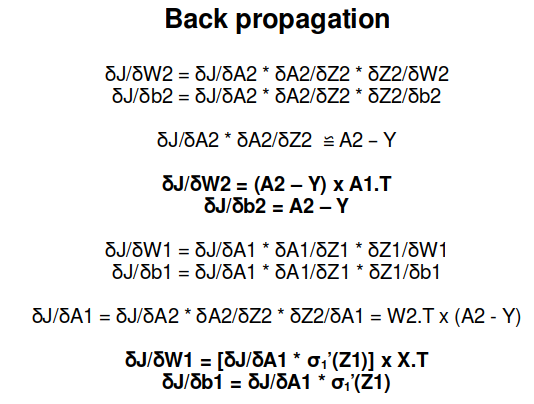

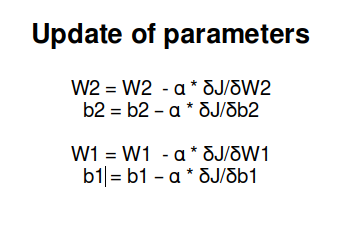

In [18]:
#codes one number
def onehot_code(number):
    number_coded = np.zeros(10)
    number_coded[number] = 1
    
    return number_coded

#decodes one number
def onehot_decode(y):
    y = y.reshape((10,1))
    index = np.argmax(y, axis=0)
    return index[0]

#codes whole y dataset
def code_y(y):
    y_coded = []
    for number in y:
        coded = onehot_code(number)
        y_coded.append(coded)
    y_coded = np.array(y_coded)
    return y_coded

def softmax(Z):
    A= np.exp(Z) / np.sum(np.exp(Z), axis=0)  
    return A  



def ReLU(Z):
    A = np.maximum(0,Z)
    
    return A

def d_ReLU(Z):
    return Z > 0

def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(10, 128) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2


        

In [19]:
#Dataset from tensorflow

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.array(x_train)
x_train = np.reshape(x_train, (60000,784))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (10000,784))

y_train_raw = np.array(y_train)
y_test_raw = np.array(y_test)

y_train = code_y(y_train_raw)
y_train = np.transpose(y_train)
y_test = code_y(y_test_raw)
y_test = np.transpose(y_test)

x_train = np.transpose(x_train)/255
x_test = np .transpose(x_test)/255  





Show selected number as image

In [20]:
class Model:

    def __init__(self, x_train, y_train, x_test, y_test, lr):
        self.W1, self.b1, self.W2, self.b2 = init_params()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.lr = lr
        
    def forward(self, x_train):
        Z1 = np.dot(self.W1, x_train) + self.b1
        A1 = ReLU(Z1)
        Z2 = np.dot(self.W2,A1) + self.b2
        A2 = softmax(Z2)
        
        return Z1, A1, Z2, A2
    
    def backprop(self, Z1, A1, Z2, A2, X, Y, batch_size):
        
        dC_dW2 = np.dot(A2 - Y, A1.T)*(1/batch_size)
        dC_db2 = np.sum(A2 - Y, axis=1)*(1/batch_size)
        
        dC_dA1 = np.dot(self.W2.T, A2 - Y)
        dC_dW1 = np.dot(dC_dA1*d_ReLU(Z1),X.T)*(1/batch_size)
        dC_db1 = np.sum(dC_dA1*d_ReLU(Z1), axis=1)*(1/batch_size)
        
        return dC_dW2, dC_db2, dC_dW1, dC_db1
    
    
    def update_params(self, dW2, db2, dW1, db1):
        
        self.W2 = self.W2 - dW2 * self.lr
        self.b2 = self.b2 - db2.reshape((10,1)) * self.lr
        
        self.W1 = self.W1 - dW1 * self.lr
        self.b1 = self.b1 - db1.reshape((128,1)) * self.lr
        
        
    def train_score(self):
        m = self.x_train.shape[1]
        score = 0       
        Z1, A1, Z2, A2 = self.forward(self.x_train)
        
        for i in range(m):
                
            if onehot_decode(self.y_train[:,i]) == onehot_decode(A2[:,i]):     
                score += 1
        return score / m
    
    def test_score(self):
        m = self.x_test.shape[1]
        score = 0       
        Z1, A1, Z2, A2 = self.forward(self.x_test)
        
        for i in range(m):
                
            if onehot_decode(self.y_test[:,i]) == onehot_decode(A2[:,i]):     
                score += 1
        return score / m
      
   
    def train(self, epochs, batch_size):
        batches = self.x_train.shape[1] // batch_size
        iter_batches = list(range(0, batches*batch_size, batch_size))
        
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs} is running')
            for batch in iter_batches:
                X = self.x_train[:,batch:batch+batch_size]
                Y = self.y_train[:,batch:batch+batch_size]
            
                Z1, A1, Z2, A2 = self.forward(X)    
                dW2, db2, dW1, db1 = self.backprop(Z1, A1, Z2, A2, X, Y, batch_size)
                self.update_params(dW2, db2, dW1, db1)
                
            train_score = self.train_score()
            print(f'Score is {train_score*100}%')
        
        test_score = self.test_score()
        print(f"Test score is {test_score * 100} %")
           
    
model = Model(x_train, y_train, x_test, y_test, 0.1)

In [21]:
model.train(epochs = 50, batch_size = 256)

Epoch 1/50 is running
Score is 86.95833333333334%
Epoch 2/50 is running
Score is 90.03333333333333%
Epoch 3/50 is running
Score is 91.58%
Epoch 4/50 is running
Score is 92.50666666666667%
Epoch 5/50 is running
Score is 93.13333333333334%
Epoch 6/50 is running
Score is 93.63333333333334%
Epoch 7/50 is running
Score is 94.04%
Epoch 8/50 is running
Score is 94.39666666666666%
Epoch 9/50 is running
Score is 94.67166666666667%
Epoch 10/50 is running
Score is 94.89666666666666%
Epoch 11/50 is running
Score is 95.11333333333334%
Epoch 12/50 is running
Score is 95.32833333333333%
Epoch 13/50 is running
Score is 95.49333333333333%
Epoch 14/50 is running
Score is 95.67333333333333%
Epoch 15/50 is running
Score is 95.80833333333332%
Epoch 16/50 is running
Score is 95.97%
Epoch 17/50 is running
Score is 96.12166666666667%
Epoch 18/50 is running
Score is 96.25%
Epoch 19/50 is running
Score is 96.34%
Epoch 20/50 is running
Score is 96.43666666666667%
Epoch 21/50 is running
Score is 96.54%
Epoch 22/5